In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
%matplotlib inline

import sys
sys.path.insert(1, "..")
import ttim
print(f"ttim installed in {os.path.abspath(ttim.__file__)}")

ttim installed in /home/david/Github/ttim_db/ttim/__init__.py


In [2]:
ml = ttim.Model3D(kaq=[2, 1, 5, 10, 4], z=[10, 8, 6, 4, 2, 0], \
             Saq=[.1, .0001, .0002, .0002, .0001], \
             phreatictop=True, kzoverkh=0.1, topboundary='conf', \
             tmin=1e-3, tmax=1e3, )
w = ttim.Well(ml, 0, -25, rw=.3, tsandQ=[(0, 100)], layers=[2, 3])

dxdy = 30 * np.pi / 100 * np.cos(np.pi)
y1 = np.arange(-150, -100, 10)
x1 = (y1 + 100) * dxdy
y2 = np.linspace(-100, 100, 20)
x2 = 30 * np.sin(y2 * np.pi / 100)
xls = np.hstack((x1, x2))
yls = np.hstack((y1, y2))
xy = np.array([xls, yls]).T

ls1 = ttim.HeadLineSinkString(ml, xy=xy, tsandh='fixed', layers=[0, 1])

# create more ls elements offset by +/-dx
for dx in [100, 200]:
    ttim.HeadLineSinkString(ml, xy=xy + np.array([dx, 0]), 
                              tsandh='fixed', layers=[0, 1])
    ttim.HeadLineSinkString(ml, xy=xy - np.array([dx, 0]), 
                              tsandh='fixed', layers=[0, 1])

In [3]:
ml.initialize()

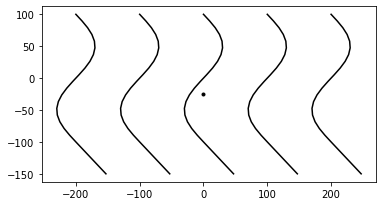

In [4]:
ml.plot()

In [5]:
ml.solve()

self.neq  242
solution complete


In [6]:
def solve(ml, returnmat=0, sendback=0, silent=False):
    """Compute solution

    """

    # Initialize elements
    ml.initialize()
    # Compute number of equations
    ml.neq = np.sum([e.nunknowns for e in ml.elementlist])
    if silent is False:
        print('ml.neq ', ml.neq)
    if ml.neq == 0:
        if silent is False:
            print('No unknowns. Solution complete')
        return
    mat = np.empty((ml.neq, ml.neq, ml.npval), 'D')
    rhs = np.empty((ml.neq, ml.ngvbc, ml.npval), 'D')
    ieq = 0
    for e in ml.elementlist:
        if e.nunknowns > 0:
            mat[ieq:ieq+e.nunknowns, :, :], rhs[ieq:ieq+e.nunknowns, :, :] = e.equation()
            ieq += e.nunknowns
    if returnmat:
        return mat, rhs
    for i in range(ml.npval):
        sol = np.linalg.solve(mat[:, :, i], rhs[:, :, i])
        icount = 0
        for e in ml.elementlist:
            for j in range(e.nunknowns):
                e.parameters[:, j, i] = sol[icount, :]
                icount += 1
            e.run_after_solve()
    if silent is False:
        print('solution complete')
    elif (silent == 'dot') or (silent == '.'):
        print('.', end='', flush=True)
    if sendback:
        return sol
    return

In [7]:
import multiprocessing as mp

def solve_mp(ml, returnmat=0, sendback=0, nproc=None, silent=False):
    """Compute solution

    """

    # Initialize elements
    ml.initialize()
    # Compute number of equations
    ml.neq = np.sum([e.nunknowns for e in ml.elementlist])
    if silent is False:
        print('ml.neq ', ml.neq)
    if ml.neq == 0:
        if silent is False:
            print('No unknowns. Solution complete')
        return
    
    # start multiprocessing
    if nproc is None:
        nproc = mp.cpu_count() - 1  # make no. of processes equal to 1 less than no. of cores

    pool = mp.Pool(processes=nproc)
    
    results = []
    for e in ml.elementlist:
        if e.nunknowns > 0:
            results.append(pool.apply_async(e.equation))
        if silent is False:
            print('.', end='', flush=True)

    pool.close()
    pool.join()
    
    mat = np.empty((ml.neq, ml.neq, ml.npval), 'D')
    rhs = np.empty((ml.neq, ml.ngvbc, ml.npval), 'D')

    ieq = 0

    for p in results:
        imat, irhs = p.get()
        nunknowns = imat.shape[0]
        mat[ieq:ieq + nunknowns, :, :] = imat
        rhs[ieq:ieq + nunknowns, :, :] = irhs
        ieq += nunknowns

    # end multiprocessing
    
    if returnmat:
        return mat, rhs
    for i in range(ml.npval):
        sol = np.linalg.solve(mat[:, :, i], rhs[:, :, i])
        icount = 0
        for e in ml.elementlist:
            for j in range(e.nunknowns):
                e.parameters[:, j, i] = sol[icount, :]
                icount += 1
            e.run_after_solve()
            
    if silent is False:
        print('solution complete')
    elif (silent == 'dot') or (silent == '.'):
        print('.', end='', flush=True)
    if sendback:
        return sol
    return

In [8]:
nprocs = [1, 2, 4, 6, 8, 12]

In [9]:
df = pd.DataFrame(index=["Normal"] + [f"MP_{i}" for i in nprocs], columns=["average time (s)", "ratio"])

In [10]:
t0 = %timeit -o solve(ml, silent=True)

12.1 s ± 42.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
df.loc["Normal", "average time (s)"] = t0.average

In [12]:
for nproc in nprocs:
    print("-"*5 + f" Nproc = {nproc} " + "-"*5)
    tmp = %timeit -o solve_mp(ml, nproc=nproc, silent=True)
    df.loc[f"MP_{nproc}", "average time (s)"] = tmp.average

----- Nproc = 1 -----
12.6 s ± 115 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
----- Nproc = 2 -----
7.73 s ± 132 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
----- Nproc = 4 -----
5.48 s ± 87.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
----- Nproc = 6 -----
3.67 s ± 155 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
----- Nproc = 8 -----
3.67 s ± 78.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
----- Nproc = 12 -----
3.77 s ± 49.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
df.loc[:, "ratio"] = df.loc["Normal", "average time (s)"] / df.loc[:, "average time (s)"]

In [35]:
def cbg(col):
    if col.name == "ratio":
        cmap = mpl.cm.Greens
    else:
        cmap = mpl.cm.RdYlGn_r
    norm = mpl.colors.LogNorm(vmin=col.min(), 
                              vmax=col.max())
    colors = []
    for val in col:
        color = mpl.colors.rgb2hex(cmap(norm(val)))
        colors.append(color)
    return [f"background-color: {color}" for color in colors]

def ctxt(col):
    if col.name == "ratio":
        cmap = mpl.cm.Greens
    else:
        cmap = mpl.cm.RdYlGn_r
    norm = mpl.colors.LogNorm(vmin=col.min(), 
                              vmax=col.max())
    colors = []
    for val in col:
        bg = cmap(norm(val))
        c = "White" if np.mean(bg[:3]) < 0.4 else "Black"
        colors.append(c)
    return [f"color: {c}" for c in colors]

def highlight_max(col):
    '''
    highlight the maximum in a Series yellow.
    '''
    if col.name == "ratio":
        is_max = col == col.max()
    else:
        return [""] * col.shape[0]
    return ['color: yellow' if v else '' for v in is_max]

In [36]:
df.style.apply(cbg, axis=0).apply(ctxt, axis=0).apply(highlight_max).set_caption("Run times")

,average time (s),ratio
Normal,12.091002,1.000000
MP_1,12.622878,0.957864
MP_2,7.730337,1.564098
MP_4,5.480398,2.206227
MP_6,3.666696,3.297520
MP_8,3.668591,3.295817
MP_12,3.766178,3.210417
